### Librerías necesarias

In [ ]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights
import pandas as pd
from PIL import Image
import numpy as np
from IPython.display import display, clear_output
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install fpdf
from fpdf import FPDF

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=81a5e9e26466136a23abb9d657412c40d213ab73cd3580e4949682ab365ddb02
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


Constantes relacionadas con el conjunto de datos y la ejecución

In [ ]:
DESCRIPTION = 'Entrenamiento con ResNet18'
TRAINING_DATE = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
DIR_RESULTS = '/content/drive/MyDrive/TFG/Results'
DIR_CSV = r'https://www.dropbox.com/scl/fi/3gbhwhov6t8hxaei9xc0p/Data_Entry_2017_v2020.csv?rlkey=pewdr248pz4bffwntjd3ulf76&e=1&st=vfdxv236&dl=1'
DIR_IMAGES = r'/content/images'
CSV_TRAINING = 'Data_Entry_2017_v2020.csv'
COLUMN_IMAGE = 'Image Index'
COLUMN_LABELS = 'Finding Labels'
LABEL_NO_FINDING = 'No Finding'

Constantes relacionadas con parámetros del entrenamiento

In [ ]:
NUM_EPOCHS = 30
BATCH_SIZE = 32
THRESHOLD = 0.5
LEARNING_RATE = 0.001
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_STATE = 42
SIZE_IMAGES = (224, 224)
DROPOUT_PROB = 0.5
SAMPLES_MC_DROPOUT = 30
UNCERTAINTY_THRESHOLD = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Constantes relacionadas con Google Colab

In [ ]:
DIR_GOOGLE_DRIVE = "/content/drive/"
CRX8_DOWNLOAD_FILES = 6

### Prepara el entorno de Colab

In [ ]:
from google.colab import drive
drive.mount(DIR_GOOGLE_DRIVE, force_remount = True)

Mounted at /content/drive/


### Descarga de las conjuntos de imágenes

In [ ]:
%%time
%cd /content/
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',	# image_01.tar.gz
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',	# image_02.tar.gz
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',	# image_03.tar.gz
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',	# image_04.tar.gz
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',	# image_05.tar.gz
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',	# image_06.tar.gz
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',	# image_07.tar.gz
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',	# image_08.tar.gz
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',	# image_09.tar.gz
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',	# image_10.tar.gz
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',	# image_11.tar.gz
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'	# image_12.tar.gz
]

!wget "{DIR_CSV}" -O "{CSV_TRAINING}"

for n, gzFileURL in enumerate(links):
    if n == CRX8_DOWNLOAD_FILES:
        break;
    gzFileName = "images_%02d.tar.gz" % (n + 1)
    !wget {gzFileURL} -O {gzFileName}
    !tar -xzf {gzFileName}
    !rm {gzFileName}

/content
--2025-01-19 04:35:16--  https://www.dropbox.com/scl/fi/3gbhwhov6t8hxaei9xc0p/Data_Entry_2017_v2020.csv?rlkey=pewdr248pz4bffwntjd3ulf76&e=1&st=vfdxv236&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5aff8cf1d1bb7d4331c18125ac.dl.dropboxusercontent.com/cd/0/inline/CiddIFdMw4YDxw-ETaJHqd0mnwJ0N-CK7gUWh0SXF3RzMM0A1IoKQngB-fckevt7ERfNPkrhug_9NHnRG0hXHm8b09-mfbbfQyjM9xGXJxQ8FMFZO3aYXgPp_8067mwwe5dRrjy_wpEDN4mW-cXD7p1I/file?dl=1# [following]
--2025-01-19 04:35:17--  https://uc5aff8cf1d1bb7d4331c18125ac.dl.dropboxusercontent.com/cd/0/inline/CiddIFdMw4YDxw-ETaJHqd0mnwJ0N-CK7gUWh0SXF3RzMM0A1IoKQngB-fckevt7ERfNPkrhug_9NHnRG0hXHm8b09-mfbbfQyjM9xGXJxQ8FMFZO3aYXgPp_8067mwwe5dRrjy_wpEDN4mW-cXD7p1I/file?dl=1
Resolving uc5aff8cf1d1bb7d4331c18125ac.dl.dropboxusercontent.com (uc5aff8cf1d1bb7d4331c18

### Carga de los datos.

Carga el dataset con las etiquetas y datos de cada radiografía y lo muestra.

In [ ]:
df_xrays = pd.read_csv(CSV_TRAINING)
df_xrays

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_001.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                57              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                80              M            PA                 2500   
4                74              F            PA                 2500   
...             ...            ...           ...                  ...   
112115           38              M            PA                 2048   
112116           28              M            PA                 2048   
112117           42              F            PA                 2048   
112118           29              F            PA                 2048   
112119           26              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  
0          2749                        0.143  0.143  
1          2729                        0.143  0.143  
2          2048                        0.168  0.168  
3          2048                        0.171  0.171  
4          2048                        0.168  0.168  
...         ...                          ...    ...  
112115     2500                        0.168  0.168  
112116     2500                        0.168  0.168  
112117     2500                        0.168  0.168  
112118     2500                        0.168  0.168  
112119     2500                        0.171  0.171  

[112120 rows x 11 columns]

Obtiene las distintas etiquetas.

In [ ]:
#  Recupera los valores de las clases, pero sin repetirse y ordenados alfabéticamente.
labels_names = list(set(label for labels in df_xrays[COLUMN_LABELS].unique() for label in labels.split('|')))
labels_names = np.sort(labels_names)

#  La etiqueta que representa que no hay enfermedad la vamos a tratar de forma diferente.
# En realidad esto sería que no hay ninguna etiqueta de enfermedad. No tendría sentido que
# se pudiera dar, por ejemplo, 'no finding|pneumonia'. Por lo tanto hay que eliminarla.
# La forma que menos problemas ha dado, es al principio dejarla como una etiqueta más.
# Una vez binarizadas las etiquetas, eliminar la columna.
labels_names = np.concatenate(((np.delete(labels_names, np.where(labels_names == LABEL_NO_FINDING)[0]), [LABEL_NO_FINDING])))

#  Cuenta las clases. Restamos la del 'No finding'.
num_labels = len(labels_names) - 1

### Arreglo de los datos.

Código para pruebas, cuando no se trabaja con todo el conjunto de imágenes.

Mira los archivos que hay en el directorio de imágenes y selecciona sólo las filas correctas del dataframe.

In [ ]:
list_xrays = os.listdir(DIR_IMAGES)
df_xrays = df_xrays[df_xrays[COLUMN_IMAGE].isin(list_xrays)].copy()
del list_xrays

Agrega la ruta del directorio de las imágenes al nombre de cada una.

In [ ]:
df_xrays[COLUMN_IMAGE] = df_xrays[COLUMN_IMAGE].apply(lambda i: os.path.join(DIR_IMAGES, i))

Binariza las etiquetas en el dataframe.

In [ ]:
#  Crear una instancia de MultiLabelBinarizer.
mlb = MultiLabelBinarizer(classes=labels_names)

#  Transforma las clases del dataframe.
vectors_one_hot_from_labels = list(mlb.fit_transform([txt_labels.split('|') for txt_labels in df_xrays[COLUMN_LABELS]]))

#  Elimina la columna correspondiente al 'No finding'.
vectors_one_hot_from_labels = np.delete(vectors_one_hot_from_labels, -1, axis=1)

#  Elimina ahora la etiqueta del 'No finding' de labels_names.
labels_names = np.delete(labels_names, np.where(labels_names == LABEL_NO_FINDING)[0])

#  Actualiza el dataframe.
df_xrays[COLUMN_LABELS] = list(vectors_one_hot_from_labels)

del vectors_one_hot_from_labels
del mlb

Muestra el conjunto resultante.

In [ ]:
df_xrays

Image Index  \
0      /content/images/00000001_000.png   
1      /content/images/00000001_001.png   
2      /content/images/00000001_002.png   
3      /content/images/00000002_000.png   
4      /content/images/00000003_001.png   
...                                 ...   
54994  /content/images/00013774_021.png   
54995  /content/images/00013774_022.png   
54996  /content/images/00013774_023.png   
54997  /content/images/00013774_025.png   
54998  /content/images/00013774_024.png   

                                   Finding Labels  Follow-up #  Patient ID  \
0      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            0           1   
1      [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            1           1   
2      [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]            2           1   
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            0           2   
4      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]            0           3   
...                                           ...          ...         ...   
54994  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]           21       13774   
54995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]           22       13774   
54996  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]           23       13774   
54997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]           24       13774   
54998  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]           25       13774   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0               57              M            PA                 2682     2749   
1               58              M            PA                 2894     2729   
2               58              M            PA                 2500     2048   
3               80              M            PA                 2500     2048   
4               74              F            PA                 2500     2048   
...            ...            ...           ...                  ...      ...   
54994           77              F            AP                 2500     2048   
54995           77              F            AP                 2500     2048   
54996           77              F            AP                 2500     2048   
54997           77              F            AP                 2500     2048   
54998           77              F            AP                 2500     2048   

       OriginalImagePixelSpacing[x     y]  
0                            0.143  0.143  
1                            0.143  0.143  
2                            0.168  0.168  
3                            0.171  0.171  
4                            0.168  0.168  
...                            ...    ...  
54994                        0.168  0.168  
54995                        0.168  0.168  
54996                        0.168  0.168  
54997                        0.168  0.168  
54998                        0.168  0.168  

[54999 rows x 11 columns]

## Entrenamiento.

Prepara los conjuntos de entrenamiento y prueba.

Cargar y dividir el dataset

In [ ]:
# Dividir el DataFrame
train_data = df_xrays.sample(frac=(1 - VAL_SIZE - TEST_SIZE), random_state=RANDOM_STATE)
df_temp = df_xrays.drop(train_data.index)
val_data = df_temp.sample(frac=(VAL_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=RANDOM_STATE)
test_data = df_temp.drop(val_data.index)

# Guardar los conjuntos divididos en archivos CSV
train_csv = "train_dataset.csv"
val_csv = "val_dataset.csv"
test_csv = "test_dataset.csv"
train_data.to_csv(train_csv, index=False)
val_data.to_csv(val_csv, index=False)
test_data.to_csv(test_csv, index=False)

Función para carga de imágenes como tensores

In [ ]:
def load_image(image_path):
    image = Image.open(image_path)

    # Convertir a escala de grises si tiene 3 canales
    if image.mode == "RGB":
        image = image.convert("L")

    # Asegurarnos de que sea compatible con transformaciones
    # Reconvertir a 3 canales artificialmente porque ResNet50 espera 3 canales
    image = image.convert("RGB")

    return transform(image)

transform = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    transforms.ToTensor(),
    # Normalización de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Carga todas las imágenes en su conjunto correspondiente (entrenamiento, validación y evaluación).

In [ ]:
train_images = []
train_labels = []
for _, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Cargando conjunto de entrenamiento", leave=False):
    train_images.append(load_image(row[COLUMN_IMAGE]))
    train_labels.append(torch.tensor(row[COLUMN_LABELS]))

val_images = []
val_labels = []
for _, row in tqdm(val_data.iterrows(), total=len(val_data), desc="Cargando conjunto de validación", leave=False):
    val_images.append(load_image(row[COLUMN_IMAGE]))
    val_labels.append(torch.tensor(row[COLUMN_LABELS]))

Creación de dataloaders

In [ ]:
# Crear DataLoaders
train_loader = DataLoader(list(zip(train_images, train_labels)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(list(zip(val_images, val_labels)), batch_size=BATCH_SIZE, shuffle=False)

Carga el modelo preentrenado

In [ ]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
#model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


Ajusta el modelo preentrenado a nuestro problema y agrégale una capa Dropout para poder calcular más tarde la medida de incertidumbre. Finalmente se envía al dispositivo

In [ ]:
model.fc = nn.Sequential(
    # Agregar capa de Dropout.
    nn.Dropout(DROPOUT_PROB),
    # Ajustar salida al número de enfermedades.
    nn.Linear(model.fc.in_features, len(train_labels[0]))
)
model = model.to(DEVICE)

Perdida y optimizador

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Función para los bucles de entrenamiento, validación y test

In [ ]:
def process_dataloader(dataloader, model, criterion, optimizer, phase="train", desc_progress=""):
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    if phase == "train":
        model.train()
    else:
        model.eval()

    for images, labels in tqdm(dataloader, desc_progress, leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # print(f"Batch size: {images.size(0)}, Labels shape: {labels.shape}")
        with torch.set_grad_enabled(phase == "train"):
            # Forward
            outputs = model(images)

            # Calcular pérdida
            criterion_loss = criterion(outputs, labels.float())

            # Backward si estamos en entrenamiento
            if phase == "train":
                optimizer.zero_grad()
                criterion_loss.backward()
                optimizer.step()

             # Convertir logits a probabilidades
            probs = torch.sigmoid(outputs)

            #  Convertir a etiquetas binarias según el umbral
            binary_preds = (probs > THRESHOLD).int()

            # Guardar predicciones y etiquetas en validación/prueba
            if phase != "train":
                all_preds.append(binary_preds.detach().cpu())
                all_labels.append(labels.detach().cpu())

            # Acumular pérdida (se acumula Perdida promedio * tanaño del batch)
            running_loss += criterion_loss.item() * images.size(0)

            # Cálculo de precisión
            correct += (binary_preds == labels.int()).all(dim=1).sum().item()  # Sumar las correctas
            total += labels.size(0)  # Contar muestras totales

    # Pérdida de la época
    epoch_loss = running_loss / len(dataloader.dataset)

    if phase != "train":
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

    # Precisión
    accuracy = correct / total

    return epoch_loss, accuracy, all_preds, all_labels

Entrenamiento

In [ ]:
# Listas para guardar las pérdidas por época
loss_train = []
loss_val = []

# Listas para guardar las precisiones por época
acc_train = []
acc_val = []

results_df = pd.DataFrame(columns=['Época', 'Pérdida entrenamiento', 'Precisión entrenamiento', 'Pérdida validación', 'Precisión validación', 'Errores'])

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    epoch_loss, accuracy, all_preds, all_labels = process_dataloader(train_loader, model, criterion, optimizer, phase="train", desc_progress=f"Entrenamiento época {epoch + 1}")
    loss_train.append(epoch_loss)
    acc_train.append(accuracy)
    print(f"Época [{epoch + 1} / {NUM_EPOCHS}]; Pérdida: {epoch_loss:.4f}; Precisión: {accuracy:.4f}")

    # Validación
    epoch_loss, accuracy, all_preds, all_labels = process_dataloader(val_loader, model, criterion, optimizer, phase="val", desc_progress=f"Validación época {epoch + 1}")
    loss_val.append(epoch_loss)
    acc_val.append(accuracy)
    num_errors = (all_preds != all_labels).any(dim=1).sum().item()

    results_df = pd.concat([results_df, pd.DataFrame({
        'Época': [f"{epoch + 1} / {NUM_EPOCHS}"] ,
        'Pérdida entrenamiento': [round(loss_train[-1], 4)],
        'Precisión entrenamiento': [round(acc_train[-1], 4)],
        'Pérdida validación': [round(loss_val[-1], 4)],
        'Precisión validación': [round(acc_val[-1], 4)],
        'Errores': [num_errors]
    })], ignore_index=True)

    clear_output(wait=True)
    display(results_df)

Época  Pérdida entrenamiento  Precisión entrenamiento  \
0    1 / 30                 0.1657                   0.5633   
1    2 / 30                 0.1565                   0.5650   
2    3 / 30                 0.1534                   0.5672   
3    4 / 30                 0.1500                   0.5682   
4    5 / 30                 0.1461                   0.5691   
5    6 / 30                 0.1427                   0.5707   
6    7 / 30                 0.1351                   0.5761   
7    8 / 30                 0.1264                   0.5897   
8    9 / 30                 0.1089                   0.6164   
9   10 / 30                 0.0869                   0.6637   
10  11 / 30                 0.0644                   0.7352   
11  12 / 30                 0.0480                   0.7978   
12  13 / 30                 0.0371                   0.8408   
13  14 / 30                 0.0288                   0.8749   
14  15 / 30                 0.0245                   0.8904   
15  16 / 30                 0.0220                   0.9020   
16  17 / 30                 0.0197                   0.9088   
17  18 / 30                 0.0192                   0.9122   
18  19 / 30                 0.0163                   0.9250   
19  20 / 30                 0.0161                   0.9254   
20  21 / 30                 0.0140                   0.9367   
21  22 / 30                 0.0136                   0.9370   
22  23 / 30                 0.0158                   0.9289   
23  24 / 30                 0.0109                   0.9497   
24  25 / 30                 0.0114                   0.9447   
25  26 / 30                 0.0132                   0.9389   
26  27 / 30                 0.0102                   0.9524   
27  28 / 30                 0.0103                   0.9515   
28  29 / 30                 0.0095                   0.9544   
29  30 / 30                 0.0100                   0.9536   

    Pérdida validación  Precisión validación Errores  
0               0.1651                0.5634    3602  
1               0.1585                0.5561    3662  
2               0.1560                0.5638    3599  
3               0.1534                0.5624    3610  
4               0.1710                0.5628    3607  
5               0.1530                0.5556    3666  
6               0.1528                0.5623    3611  
7               0.1627                0.5434    3767  
8               0.1721                0.5452    3752  
9               0.2018                0.4943    4172  
10              0.2414                0.5120    4026  
11              0.3244                0.5115    4030  
12              0.3283                0.4756    4326  
13              0.3716                0.4850    4249  
14              0.3877                0.4765    4319  
15              0.4112                0.4938    4176  
16              0.4656                0.5050    4084  
17              0.4333                0.4922    4189  
18              0.4691                0.5119    4027  
19              0.4809                0.4939    4175  
20              0.4972                0.4945    4170  
21              0.4857                0.5068    4069  
22              0.4794                0.4932    4181  
23              0.5186                0.5115    4030  
24              0.5190                0.4920    4191  
25              0.5115                0.4795    4294  
26              0.5129                0.4987    4136  
27              0.5455                0.5121    4025  
28              0.5928                0.5091    4050  
29              0.5468                0.4999    4126

### Libera la memoria de los conjuntos de entrenamiento y validación

In [ ]:
del train_loader
del train_images
del train_labels
del train_data
del val_loader
del val_images
del val_labels
del val_data

### Guardar el modelo

In [ ]:
os.makedirs(DIR_RESULTS, exist_ok=True)
torch.save(model.state_dict(), f"{DIR_RESULTS}/Model.{TRAINING_DATE}.pth")

## Evaluación

###  Carga el conjunto de test

In [ ]:
test_images = []
test_labels = []
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Cargando conjunto de evaluación", leave=False):
    test_images.append(load_image(row[COLUMN_IMAGE]))
    test_labels.append(torch.tensor(row[COLUMN_LABELS]))

test_loader = DataLoader(list(zip(test_images, test_labels)), batch_size=BATCH_SIZE, shuffle=False)

### Evaluación del módelo

In [ ]:
loss_test, acc_test, all_preds, all_labels = process_dataloader(test_loader, model, criterion, optimizer, phase="val", desc_progress=f"Evaluación")
num_errors = (all_preds != all_labels).any(dim=1).sum().item()

# Evaluar el rendimiento del modelo
accuracy = (all_preds == all_labels).float().mean()
print(f"Perdida de la evaluación: {loss_test:.4f}; Precisión de la evaluación: {acc_test:.4f}; Accuracy: {accuracy:.4f}")

Perdida de la evaluación: 0.5425; Precisión de la evaluación: 0.5097; Accuracy: 0.9434


### Métricas

In [ ]:
all_labels_np = all_labels.numpy()
all_preds_np = all_preds.numpy()

# Generar informe
report_dict = classification_report(all_labels_np, all_preds_np,  target_names=labels_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)
display(report_df)

precision  recall  f1-score  support
Atelectasis            0.3189  0.1236    0.1782    833.0
Cardiomegaly           0.6133  0.2212    0.3251    208.0
Consolidation          0.1366  0.0886    0.1075    350.0
Edema                  0.1333  0.1125    0.1220    160.0
Effusion               0.4637  0.3460    0.3963    867.0
Emphysema              0.2812  0.0471    0.0807    191.0
Fibrosis               0.1500  0.0199    0.0351    151.0
Hernia                 0.0000  0.0000    0.0000     19.0
Infiltration           0.3367  0.2409    0.2808   1258.0
Mass                   0.2991  0.1882    0.2310    356.0
Nodule                 0.1608  0.0541    0.0810    425.0
Pleural_Thickening     0.0789  0.0131    0.0225    229.0
Pneumonia              0.0833  0.0103    0.0183     97.0
Pneumothorax           0.2865  0.1576    0.2033    349.0
micro avg              0.3237  0.1751    0.2273   5493.0
macro avg              0.2387  0.1159    0.1487   5493.0
weighted avg           0.3032  0.1751    0.2158   5493.0
samples avg            0.0920  0.0765    0.0779   5493.0

In [ ]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = f1_score(all_labels, all_preds, average='micro')

print(f"Precisión: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precisión: 0.3237, Recall: 0.1751, F1-score: 0.2273


In [ ]:
auc = roc_auc_score(all_labels, all_preds, average='macro', multi_class='ovr')
print(f"AUC: {auc:.4f}")

AUC: 0.5484


#### Curvas de Pérdida

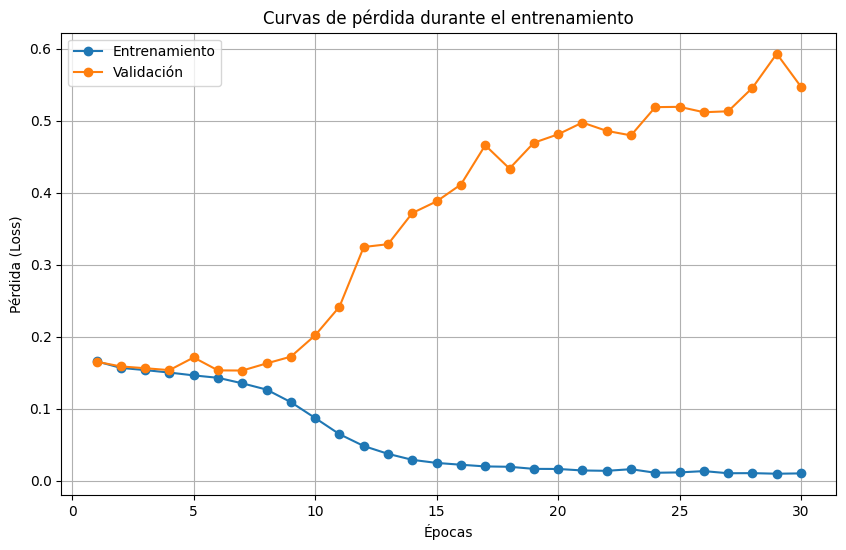

In [ ]:
epochs = range(1, len(loss_train) + 1)  # Número de épocas

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Entrenamiento', marker='o')
plt.plot(epochs, loss_val, label='Validación', marker='o')
plt.title('Curvas de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.savefig(f"{DIR_RESULTS}/loss.{TRAINING_DATE}.png")
plt.show()

#### Precisión

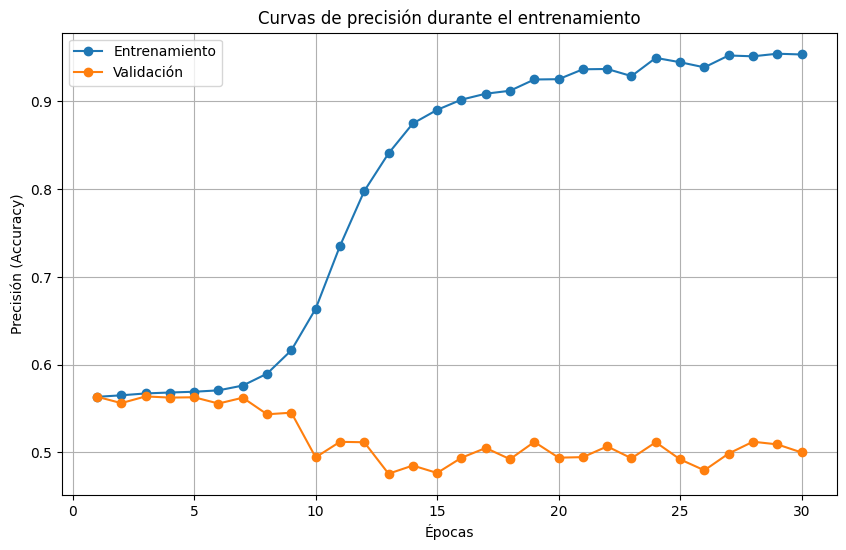

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_train, label='Entrenamiento', marker='o')
plt.plot(epochs, acc_val, label='Validación', marker='o')
plt.title('Curvas de precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.legend()
plt.grid(True)
plt.savefig(f"{DIR_RESULTS}/accuracy.{TRAINING_DATE}.png")
plt.show()

#### Matriz de Confusión

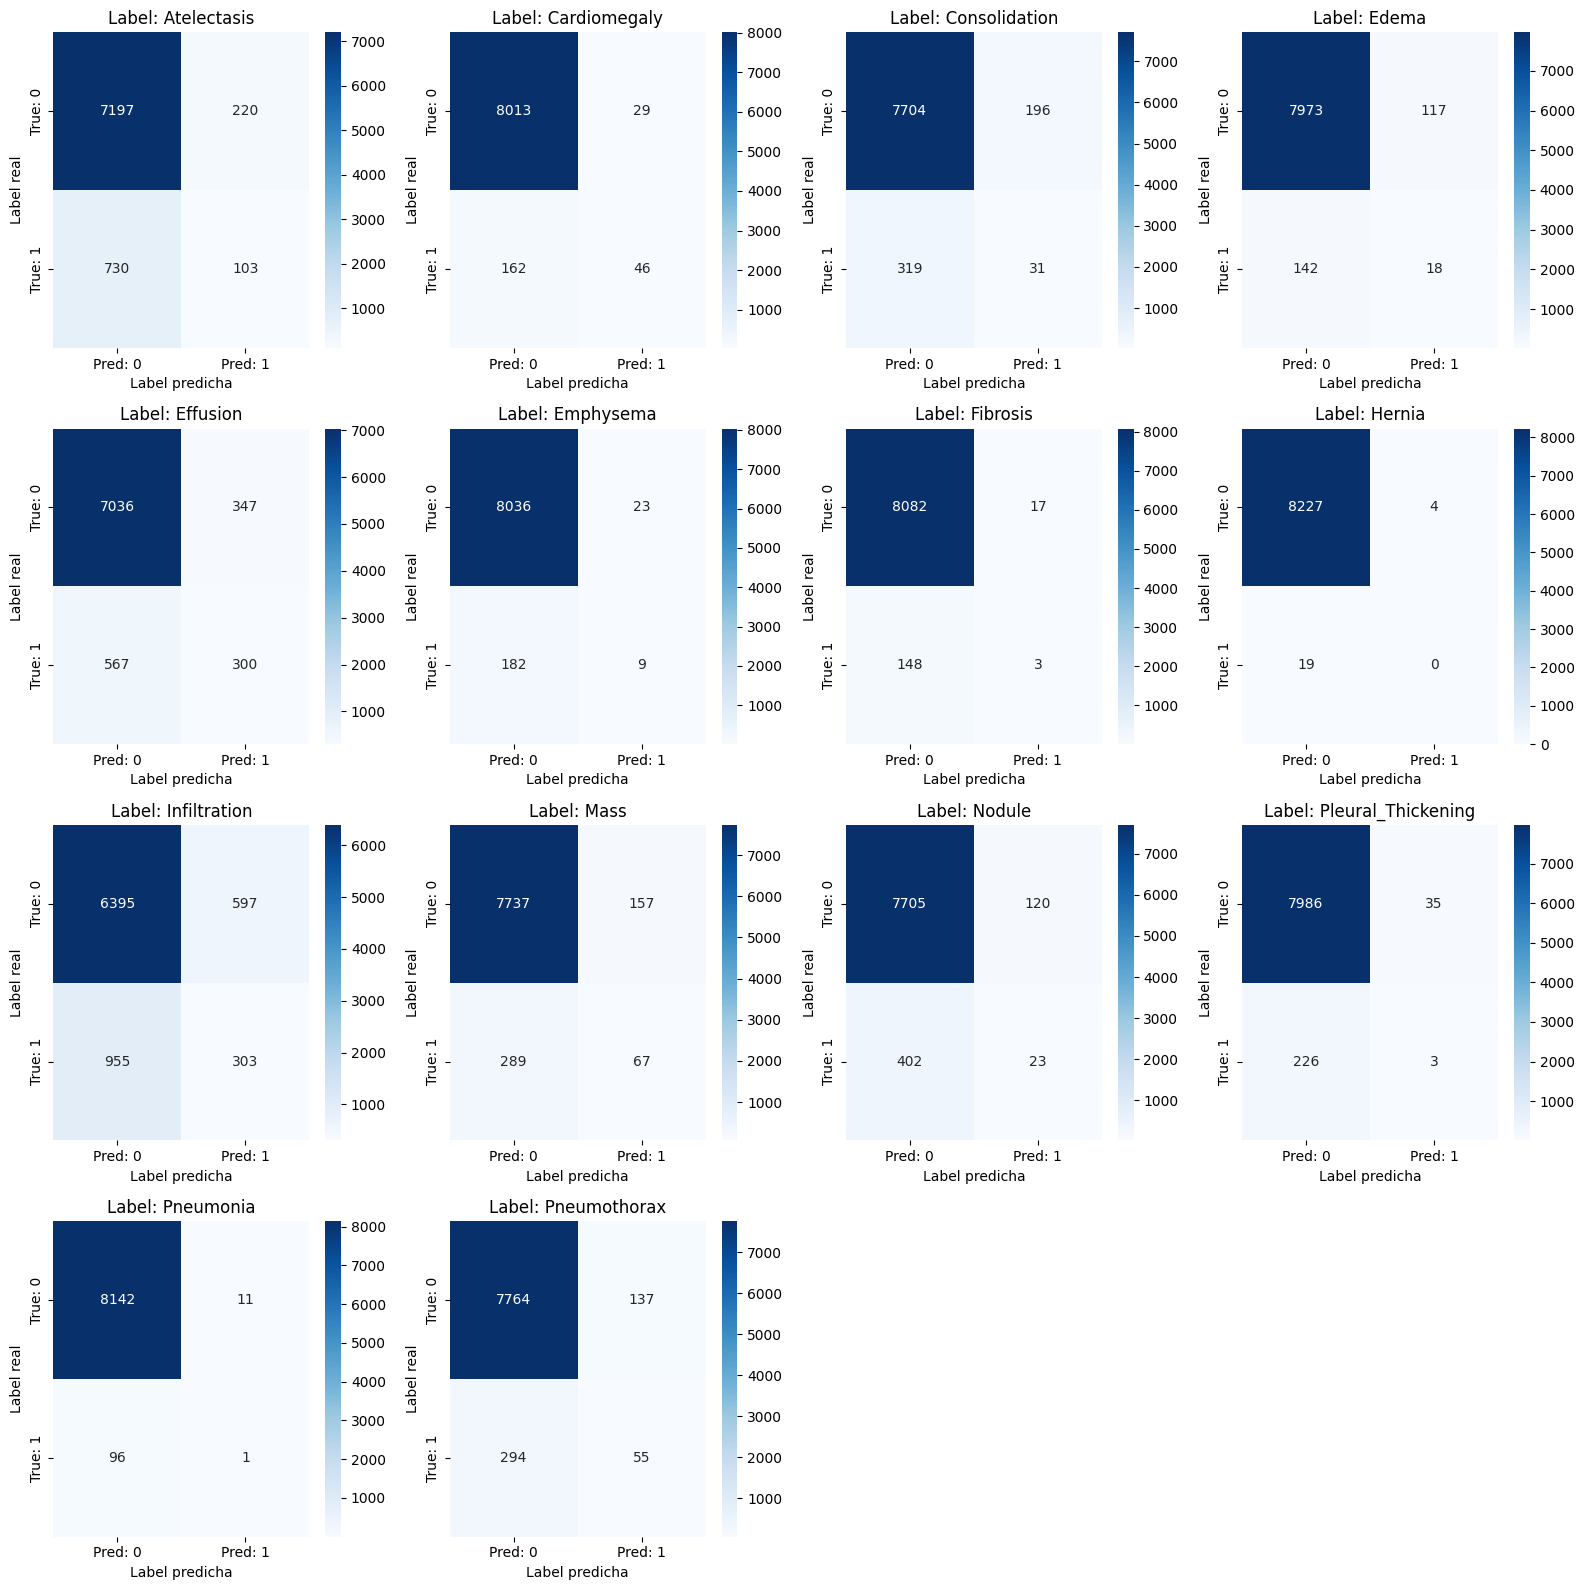

In [ ]:
y_true = all_labels.numpy()
y_pred = all_preds.numpy()

# Calcular la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_true, y_pred)

num_cols = 4
num_rows = (num_labels + num_cols - 1) // num_cols

# Crear el gráfico con subgráficas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))

# Aplanar los ejes para poder acceder a ellos de manera más sencilla
axes = axes.flatten()

# Iterar sobre las etiquetas y mostrar cada matriz de confusión
for i in range(num_labels):
    ax = axes[i]
    cm = mcm[i]

    # Visualizamos la matriz de confusión para la etiqueta
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"], ax=ax)
    ax.set_title(f'Label: {labels_names[i]}')
    ax.set_xlabel('Label predicha')
    ax.set_ylabel('Label real')

# Eliminar ejes vacíos
for i in range(num_labels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(f"{DIR_RESULTS}/confusion_matrix.{TRAINING_DATE}.png")
plt.show()

### Ejemplos de muestras

In [ ]:
def plot_predictions_grid(images, true_labels, pred_labels, class_names, num_images=80, rows=20, cols=4):
    # Filtrar imágenes donde true_labels tiene al menos un valor en 1
    mask = (true_labels.sum(dim=1) > 0).cpu().numpy()
    images = [img for img, keep in zip(images, mask) if keep]
    true_labels = true_labels[mask]
    pred_labels = pred_labels[mask]

    # Asegurarse de no exceder el número de imágenes
    num_images = min(num_images, len(images))
    fig = plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(num_images):
        img = images[i].cpu().numpy()

        # Convertir a escala de grises si tiene 3 canales
        if img.shape[0] == 3:
            img = img.mean(axis=0)

        true_label = true_labels[i].cpu().numpy()
        pred_label = pred_labels[i].cpu().numpy()

        # Crear texto verde para etiquetas reales
        true_text = "True: "
        for j in range(len(class_names)):
            if true_label[j] == 1:
                color = "green" if pred_label[j] == 1 else "red"
                true_text += f"{class_names[j]} "  # Agregar etiqueta con color

        # Crear texto rojo para las predicciones
        pred_text = "Pred: "
        for j in range(len(class_names)):
            if pred_label[j] == 1:
                color = "green" if true_label[j] == 1 else "red"
                pred_text += f"{class_names[j]} "

        # Mostrar imagen
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        ax.text(
            0.5,
            -0.1,
            true_text,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )
        ax.text(
            0.5,
            -0.2,
            pred_text,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )

    plt.tight_layout()
    plt.show()
    return fig

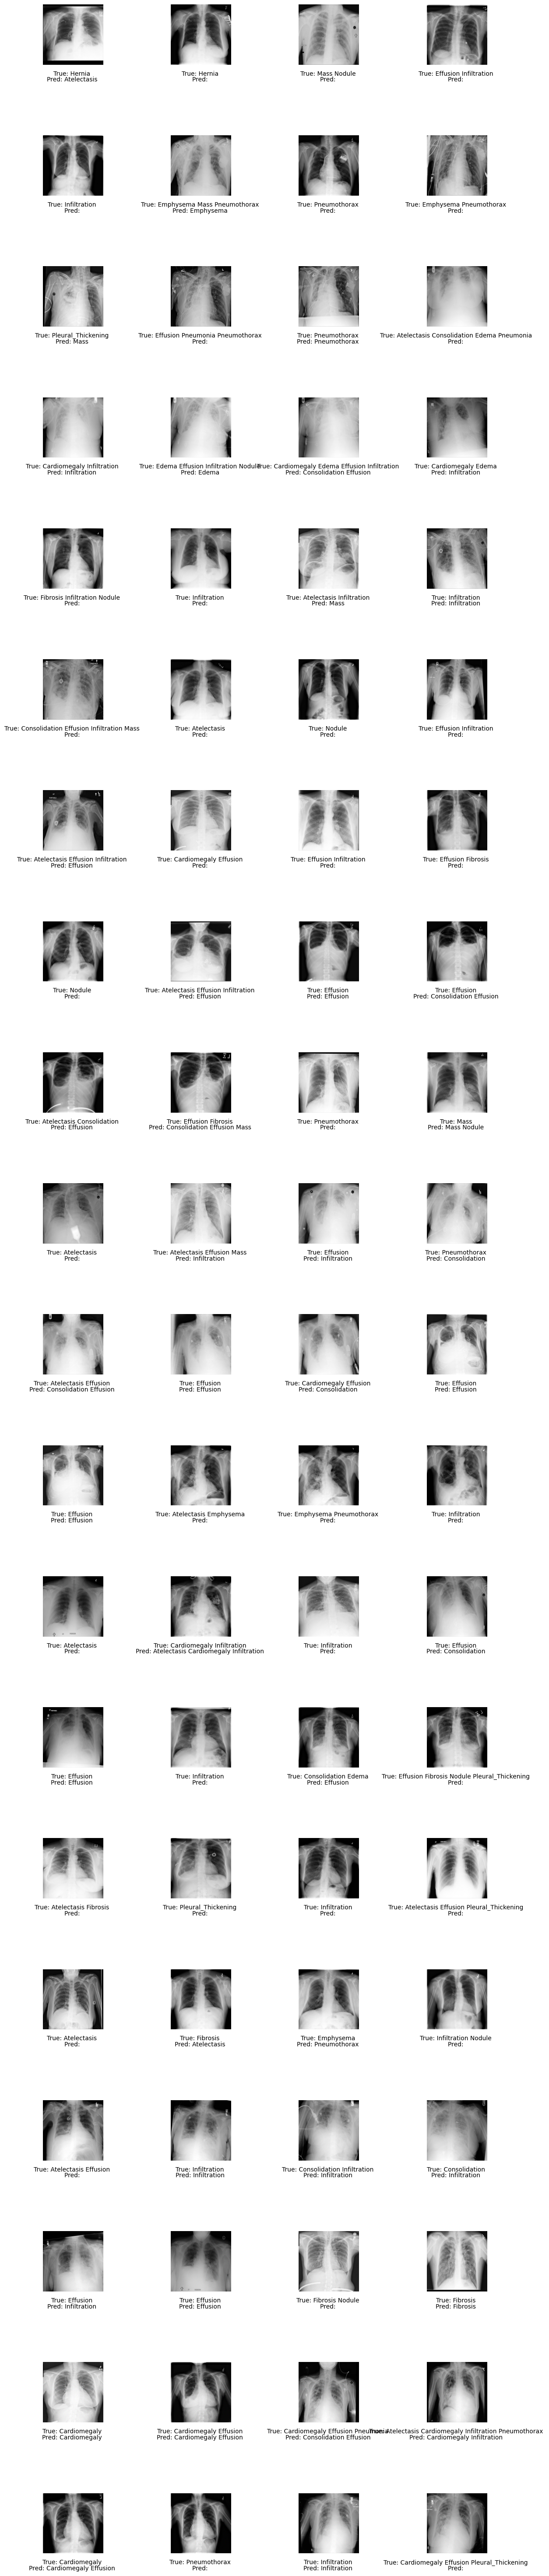

In [ ]:
fig_samples = plot_predictions_grid(test_images, all_labels, all_preds, labels_names, num_images=80, rows=20, cols=4)
fig_samples.savefig(f"{DIR_RESULTS}/fig_samples.{TRAINING_DATE}.png")

### Genera el Informe

In [ ]:
def add_dataframe(pdf, df):
	pdf.set_font('Arial', '', 8)
	pdf.ln(10)

	col_widths = []
	for col in df.columns:
		max_width = max(df[col].astype(str).apply(len).max(), len(col))
		col_widths.append(max_width * 2)

	index_width = max(df.index.astype(str).map(len).max(), len(str(df.index.name) if df.index.name else '#')) * 2.7
	col_widths.insert(0, index_width)

	row_height = pdf.font_size * 1.5

	pdf.cell(col_widths[0], row_height, '#', border=1)
	for i, col in enumerate(df.columns):
		pdf.cell(col_widths[i + 1], row_height, col, border=1)
	pdf.ln(row_height)

	for i in range(len(df)):
		pdf.cell(col_widths[0], row_height, str(df.index[i]), border=1)  # Row number
		for j, col in enumerate(df.columns):
			pdf.cell(col_widths[j + 1], row_height, str(df.iloc[i, j]), border=1)
		pdf.ln(row_height)

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)

# Título
pdf.set_font("Arial", style="B", size=14)
pdf.cell(0, 10, DESCRIPTION, ln=True, align="C")
pdf.cell(0, 10, TRAINING_DATE, ln=True, align="C")
pdf.ln(10)

pdf.set_font("Arial", style="B", size=12)
pdf.cell(0, 10, "Resultados del entrenamiento", ln=True, align="L")
add_dataframe(pdf, results_df)
pdf.ln(10)

pdf.set_font("Arial", style="B", size=12)
pdf.cell(0, 10, "Métricas de Validación", ln=True, align="L")
add_dataframe(pdf, report_df)

pdf.add_page()
pdf.image(f"{DIR_RESULTS}/loss.{TRAINING_DATE}.png", x=10, w=190)
pdf.ln(10)
pdf.image(f"{DIR_RESULTS}/accuracy.{TRAINING_DATE}.png", x=10, w=190)

pdf.add_page()
pdf.image(f"{DIR_RESULTS}/confusion_matrix.{TRAINING_DATE}.png", x=10, w=190)

pdf.add_page()
pdf.image(f"{DIR_RESULTS}/fig_samples.{TRAINING_DATE}.png", x=10, w=190)

output_path = f"{DIR_RESULTS}/Report.{TRAINING_DATE}.pdf"
pdf.output(output_path)
print(f"Informe {output_path} generado.")

Informe /content/drive/MyDrive/TFG/Results/Report.2025-01-19-04-34-46.pdf generado.


## Medida de la incertidumbre

In [ ]:
def mc_dropout_inference(model, dataloader, num_samples):
    # Configurar el modelo en modo evaluación
    model.eval()

    # Activar capa Dropout
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()

    all_preds = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(DEVICE)
            batch_preds = []

            for _ in range(num_samples):
                outputs = model(images)
                probs = torch.sigmoid(outputs)
                batch_preds.append(probs.cpu().numpy())

            batch_preds = torch.tensor(np.array(batch_preds))
            all_preds.append(batch_preds)

    all_preds = torch.cat(all_preds, dim=1)
    pred_mean = torch.mean(all_preds, dim=0)
    pred_var = torch.var(all_preds, dim=0)

    return pred_mean, pred_var

In [ ]:
# Evaluar con MC Dropout
pred_mean, pred_var = mc_dropout_inference(model, test_loader, SAMPLES_MC_DROPOUT)

### Estadísticas globales

In [ ]:
mean_var_mean = pred_var.mean().item()  # Media de las varianzas
mean_var_std = pred_var.std().item()   # Desviación estándar de las varianzas

print(f"Media de las varianzas: {mean_var_mean:.4f}")
print(f"Desviación estándar de las varianzas: {mean_var_std:.4f}")

Media de las varianzas: 0.0016
Desviación estándar de las varianzas: 0.0081


### Resumen general

In [ ]:
image_names = test_data[COLUMN_IMAGE].apply(os.path.basename).tolist()
mean_df = pd.DataFrame(pred_mean.numpy(), columns=labels_names, index=image_names)
var_df = pd.DataFrame(pred_var.numpy(), columns=labels_names, index=image_names)

# Combinar medias y varianzas
summary_df = mean_df.copy()
for col in labels_names:
    summary_df[col] = mean_df[col].map(lambda x: f"{x:.2f}") + " ± " + var_df[col].map(lambda x: f"{x:.2f}")

summary_df.head(20)

Atelectasis Cardiomegaly Consolidation        Edema  \
00000003_002.png  0.55 ± 0.04  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000003_006.png  0.14 ± 0.01  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000004_000.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000005_002.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000005_003.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000005_007.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000007_000.png  0.99 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000010_000.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000011_008.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_032.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_039.png  0.02 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_001.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_003.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_010.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_011.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_014.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000032_012.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.13 ± 0.02   
00000032_022.png  0.00 ± 0.00  0.01 ± 0.00   0.01 ± 0.00  0.11 ± 0.02   
00000032_031.png  0.00 ± 0.00  0.12 ± 0.01   0.17 ± 0.04  0.00 ± 0.00   
00000032_041.png  0.00 ± 0.00  0.14 ± 0.04   0.00 ± 0.00  0.99 ± 0.00   

                     Effusion    Emphysema     Fibrosis       Hernia  \
00000003_002.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000003_006.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.19 ± 0.06   
00000004_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000005_002.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000005_003.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000005_007.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000007_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000010_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000011_008.png  0.02 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_032.png  0.02 ± 0.00  1.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_039.png  0.00 ± 0.00  0.04 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_001.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_003.png  0.03 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_010.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_011.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_014.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_012.png  0.16 ± 0.01  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_022.png  1.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_031.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_041.png  0.06 ± 0.01  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   

                 Infiltration         Mass       Nodule Pleural_Thickening  \
00000003_002.png  0.01 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000003_006.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000004_000.png  0.32 ± 0.04  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000005_002.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000005_003.png  0.52 ± 0.03  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000005_007.png  0.00 ± 0.00  0.00 ± 0.00  0.01 ± 0.00        0.00 ± 0.00   
00000007_000.png  0.01 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000010_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000011_008.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000013_032.png  0.00 ± 0.00  0.06 ± 0.01  0.00 ± 0.00        0.00 ± 0.00   
00000013_039.png  0.10 ± 0.01  0.01 ± 0.00  0.02 ± 0.00        0.00 ± 0.00   
00000013_001.png  0.36 ± 0.06  0.00

### Casos problemáticos

In [ ]:
# Identificar patologías inciertas
cases = []
for i, (mean, var) in enumerate(zip(pred_mean, pred_var)):
    for label, m, v in zip(labels_names, mean.numpy(), var.numpy()):
        # Comprobar si la varianza puede hacer que la probabilidad de la etiqueta pase del umbral de predicción
        if v >= UNCERTAINTY_THRESHOLD and ((m < THRESHOLD and (m + v) >= THRESHOLD)  or (m >= THRESHOLD and (m - v) < THRESHOLD)):
            cases.append({
                "Radiografía": image_names[i],
                "Etiqueta Incierta": label,
                "Probabilidad": f"{m:.2f}",
                "Varianza": f"{v:.2f}"
            })

# Crear tabla de casos inciertos
cases_df = pd.DataFrame(cases)
cases_df.head(20)

Radiografía Etiqueta Incierta Probabilidad Varianza
0   00000032_041.png      Infiltration         0.47     0.07
1   00000046_000.png              Mass         0.47     0.07
2   00000061_018.png            Nodule         0.50     0.07
3   00000132_001.png      Infiltration         0.48     0.05
4   00000172_006.png      Pneumothorax         0.46     0.09
5   00000181_058.png     Consolidation         0.47     0.06
6   00000210_001.png             Edema         0.50     0.06
7   00000211_036.png            Nodule         0.54     0.06
8   00000231_000.png      Infiltration         0.46     0.06
9   00000315_000.png          Effusion         0.50     0.07
10  00000331_002.png       Atelectasis         0.55     0.07
11  00000334_005.png          Fibrosis         0.52     0.07
12  00000360_007.png          Effusion         0.46     0.09
13  00000372_003.png         Emphysema         0.52     0.09
14  00000402_010.png          Effusion         0.44     0.08
15  00000459_017.png              Mass         0.55     0.07
16  00000468_029.png      Pneumothorax         0.43     0.09
17  00000583_035.png     Consolidation         0.53     0.06
18  00000625_001.png            Nodule         0.52     0.07
19  00000796_000.png            Nodule         0.47     0.08

### Distribución de las varianzas

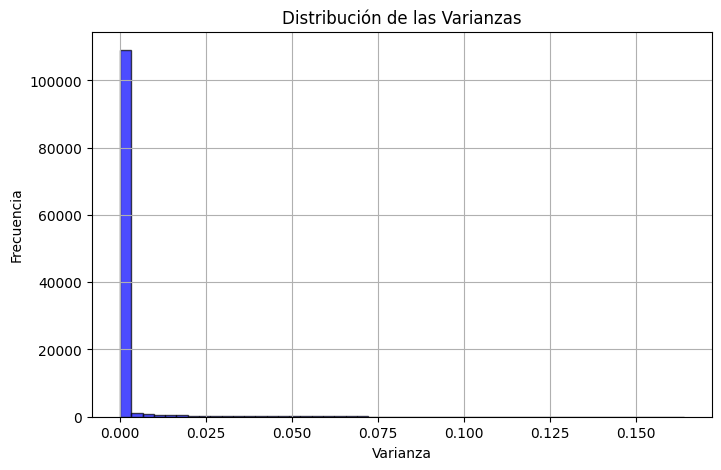

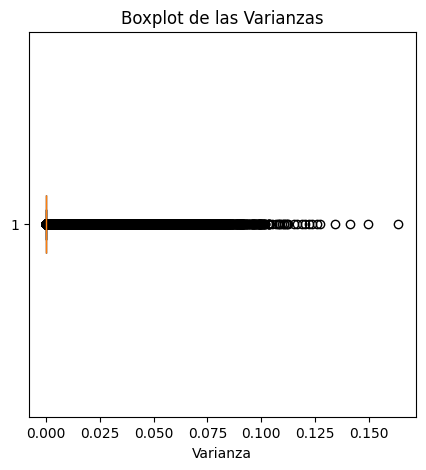

In [ ]:
# Aplanar las varianzas para representar todas las etiquetas de todas las imágenes
var_flattened = pred_var.flatten().numpy()

# Histograma
plt.figure(figsize=(8, 5))
plt.hist(var_flattened, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribución de las Varianzas")
plt.xlabel("Varianza")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

# Boxplot
plt.figure(figsize=(5, 5))
plt.boxplot(var_flattened, vert=False, patch_artist=True)
plt.title("Boxplot de las Varianzas")
plt.xlabel("Varianza")
plt.show()

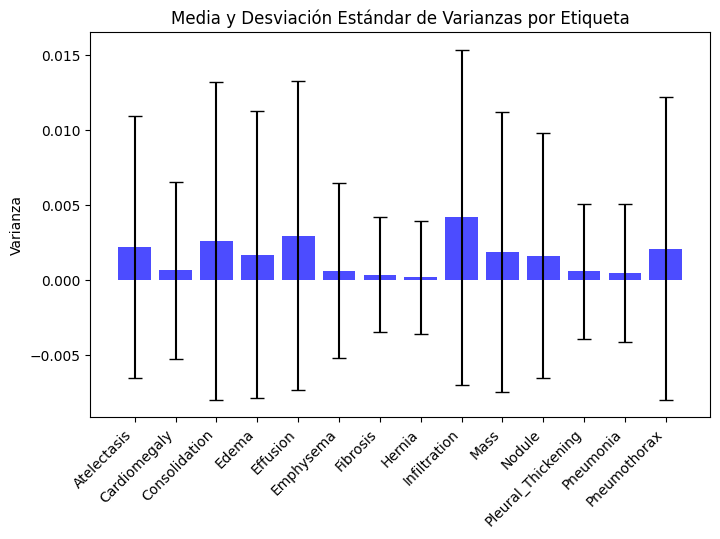

In [ ]:
# Media de la varianza por etiqueta.
label_var_mean = pred_var.mean(dim=0).numpy()

# Desviación estándar de la varianza por etiqueta
label_var_std = pred_var.std(dim=0).numpy()

plt.figure(figsize=(8, 5))
plt.bar(labels_names, label_var_mean, yerr=label_var_std, capsize=5, alpha=0.7, color='blue')
plt.title("Media y Desviación Estándar de Varianzas por Etiqueta")
plt.ylabel("Varianza")
plt.xticks(rotation=45, ha="right")  # Rotar 45° y alinear a la derecha
plt.show()

### Visualización

In [ ]:
def plot_predictions_grid2(images, true_labels, pred_labels, confidences, variances, class_names, image_names, num_images=80, rows=20, cols=4):
    # Filtrar imágenes donde true_labels tiene al menos un valor en 1
    mask = (true_labels.sum(dim=1) > 0).cpu().numpy()
    images = [img for img, keep in zip(images, mask) if keep]
    true_labels = true_labels[mask]
    pred_labels = pred_labels[mask]
    confidences = confidences[mask]
    variances = variances[mask]
    image_names = [name for name, keep in zip(image_names, mask) if keep]

    # Asegurarse de no exceder el número de imágenes
    num_images = min(num_images, len(images))

    # Calcular el tamaño dinámico basado en el número de etiquetas
    extra_space_per_label = 0.1  # Espacio adicional por etiqueta
    total_extra_space = len(class_names) * extra_space_per_label
    fig_height_per_row = 5 + total_extra_space  # Altura de cada fila ajustada dinámicamente

    # Crear figura con tamaño ajustado
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * fig_height_per_row))
    axes = axes.flatten()  # Convertir a lista para indexar fácilmente

    for i in range(num_images):
        ax = axes[i]

        img = images[i].cpu().numpy()
        if img.shape[0] == 3:
            img = img.mean(axis=0)

        true_label = true_labels[i].cpu().numpy()
        pred_label = pred_labels[i].cpu().numpy()
        confidence = confidences[i].cpu().numpy()
        variance = variances[i].cpu().numpy()
        image_name = image_names[i]

        # Mostrar imagen
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        # Añadir texto: Nombre de la imagen
        ax.text(
            0.5,
            -0.05,
            f"Name: {image_name}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )

        # Añadir texto: True y Pred
        ax.text(
            0.5,
            -0.15,
            f"True: {' '.join([class_names[j] for j in range(len(class_names)) if true_label[j] == 1])}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )
        ax.text(
            0.5,
            -0.25,
            f"Pred: {' '.join([class_names[j] for j in range(len(class_names)) if pred_label[j] == 1])}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )

        # Añadir filas con probabilidades y varianzas
        for j in range(len(class_names)):
            ax.text(
                0.5,
                -0.35 - (0.1 * j),
                f"{class_names[j]}: {confidence[j]:.2f} ± {variance[j]:.2f}",
                ha="center",
                va="top",
                transform=ax.transAxes,
                fontsize=8,
                color="black",
            )

    # Ocultar los ejes vacíos (si hay menos imágenes que subplots)
    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    # Ajustar espacio entre filas y columnas
    plt.subplots_adjust(hspace=1 + total_extra_space, wspace=0.5)
    plt.show()
    return fig

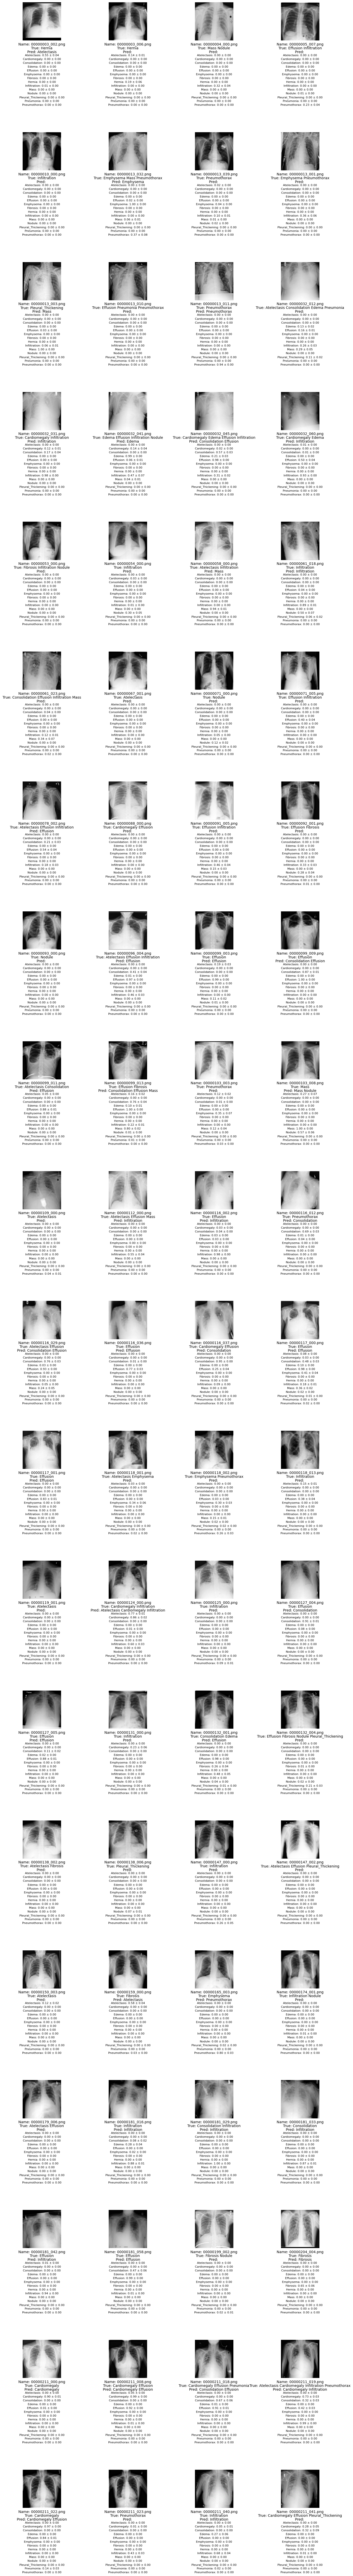

In [ ]:
fig_samples = plot_predictions_grid2(test_images, all_labels, all_preds, pred_mean, pred_var, labels_names, image_names, num_images=80, rows=20, cols=4)